In [200]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [201]:
# accsess the data files and dir
cancer_rays_dir     = os.listdir("./input/sample") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str ="./input/sample/"

In [202]:
# os.mkdir(all_rays_dir)
all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [203]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['8863', '8864', '8865', '8867', '8913', '8914', '8916']
7


In [204]:
for patient in cancer_rays_dir:   
    path_0 = cancer_rays_dir_str + str(patient) + '/0'
    path_1 = cancer_rays_dir_str + str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [205]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

6645

In [206]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

,image_id
0,8863_idx5_x1001_y1001_class0.png
1,8863_idx5_x1001_y1051_class0.png
2,8863_idx5_x1001_y1101_class0.png
3,8863_idx5_x1001_y1151_class0.png
4,8863_idx5_x1001_y1201_class0.png


In [207]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

,image_id,target
0,8863_idx5_x1001_y1001_class0.png,0
1,8863_idx5_x1001_y1051_class0.png,0
2,8863_idx5_x1001_y1101_class0.png,0
3,8863_idx5_x1001_y1151_class0.png,0
4,8863_idx5_x1001_y1201_class0.png,0
5,8863_idx5_x1001_y1251_class0.png,0
6,8863_idx5_x1001_y1301_class0.png,0
7,8863_idx5_x1001_y1351_class0.png,0
8,8863_idx5_x1001_y1401_class0.png,0
9,8863_idx5_x1001_y1451_class0.png,0


In [208]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

,image_id,target,patient_id
0,8863_idx5_x1001_y1001_class0.png,0,8863
1,8863_idx5_x1001_y1051_class0.png,0,8863
2,8863_idx5_x1001_y1101_class0.png,0,8863
3,8863_idx5_x1001_y1151_class0.png,0,8863
4,8863_idx5_x1001_y1201_class0.png,0,8863


In [209]:
data['target'].value_counts()

0    5625
1    1020
Name: target, dtype: int64

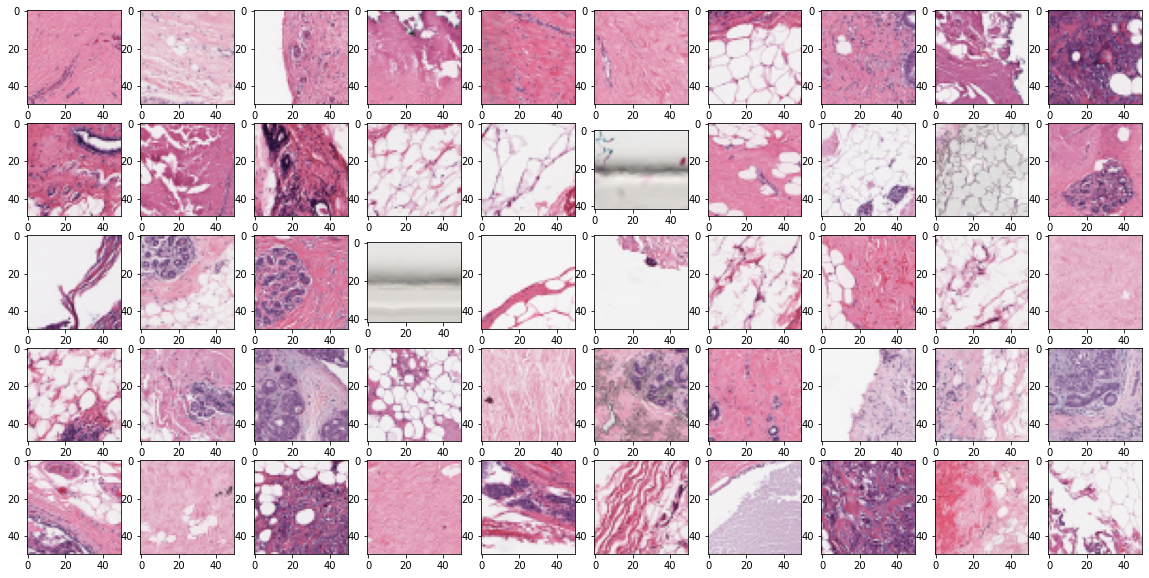

In [210]:
data.target = data.target.astype(np.int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


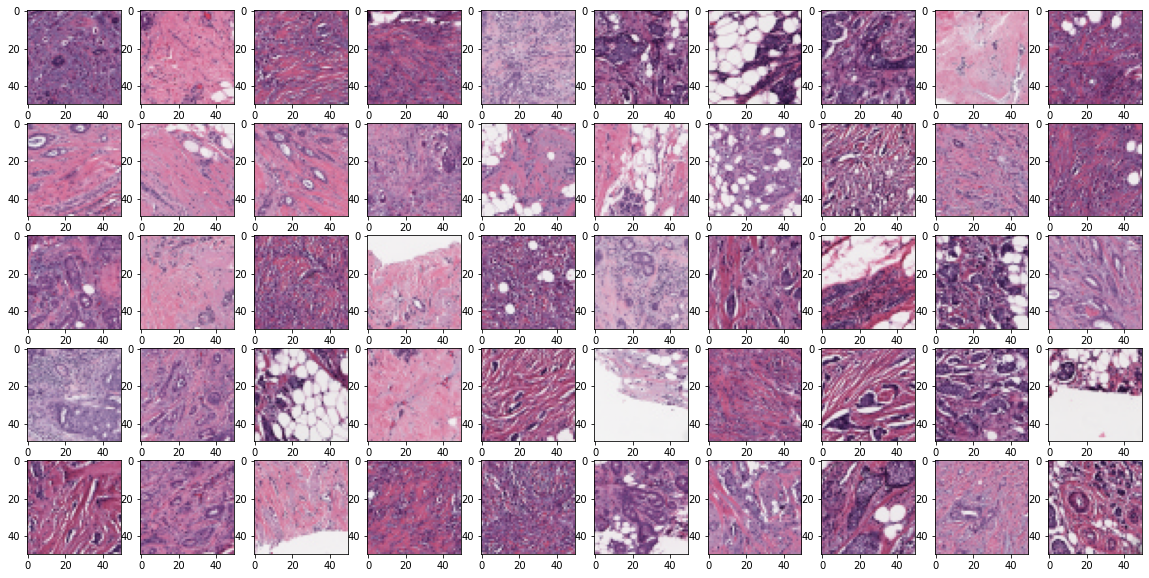

In [211]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [212]:
os.mkdir('image_processing') #We create a new file to process the data in
os.mkdir('image_processing/noise_images')

In [213]:
for normal_image in all_rays_dir_lst :
    path        = all_rays_dir+'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)

In [214]:
os.mkdir( 'image_processing/processd_data_train')
os.mkdir( 'image_processing/processd_data_test')
os.mkdir( 'image_processing/processd_data_train/zeros')
os.mkdir( 'image_processing/processd_data_train/ones')
os.mkdir( 'image_processing/processd_data_test/zeros')
os.mkdir( 'image_processing/processd_data_test/ones')

In [215]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

,image_id
0,8863_idx5_x1001_y1001_class0.png
1,8863_idx5_x1001_y1051_class0.png
2,8863_idx5_x1001_y1101_class0.png
3,8863_idx5_x1001_y1151_class0.png
4,8863_idx5_x1001_y1201_class0.png


In [216]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

,image_id,target
0,8863_idx5_x1001_y1001_class0.png,0
1,8863_idx5_x1001_y1051_class0.png,0
2,8863_idx5_x1001_y1101_class0.png,0
3,8863_idx5_x1001_y1151_class0.png,0
4,8863_idx5_x1001_y1201_class0.png,0
5,8863_idx5_x1001_y1251_class0.png,0
6,8863_idx5_x1001_y1301_class0.png,0
7,8863_idx5_x1001_y1351_class0.png,0
8,8863_idx5_x1001_y1401_class0.png,0
9,8863_idx5_x1001_y1451_class0.png,0


In [217]:
processd_data['target'].value_counts()

0    5625
1    1020
Name: target, dtype: int64

In [218]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [219]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)

In [220]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [221]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

5062
918
563
102


In [222]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

,image_id,target
0,8863_idx5_x1001_y1001_class0.png,0
1,8863_idx5_x1001_y1051_class0.png,0
2,8863_idx5_x1001_y1101_class0.png,0
3,8863_idx5_x1001_y1151_class0.png,0
4,8863_idx5_x1001_y1201_class0.png,0
5,8863_idx5_x1001_y1251_class0.png,0
6,8863_idx5_x1001_y1301_class0.png,0
7,8863_idx5_x1001_y1351_class0.png,0
8,8863_idx5_x1001_y1401_class0.png,0
9,8863_idx5_x1001_y1451_class0.png,0


In [223]:
os.mkdir( 'image_processing/model_tst')
os.mkdir( 'image_processing/model_tst/trainig')
os.mkdir( 'image_processing/model_tst/testing')          
os.mkdir( 'image_processing/model_tst/trainig/zeros')
os.mkdir( 'image_processing/model_tst/trainig/ones')
os.mkdir( 'image_processing/model_tst/testing/zeros')
os.mkdir( 'image_processing/model_tst/testing/ones')

In [227]:
processd_data['target'].value_counts()

0    5625
1    1020
Name: target, dtype: int64

In [230]:
df_0 = processd_data[processd_data['target'] == '0'].sample(5624, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(1019, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst) 

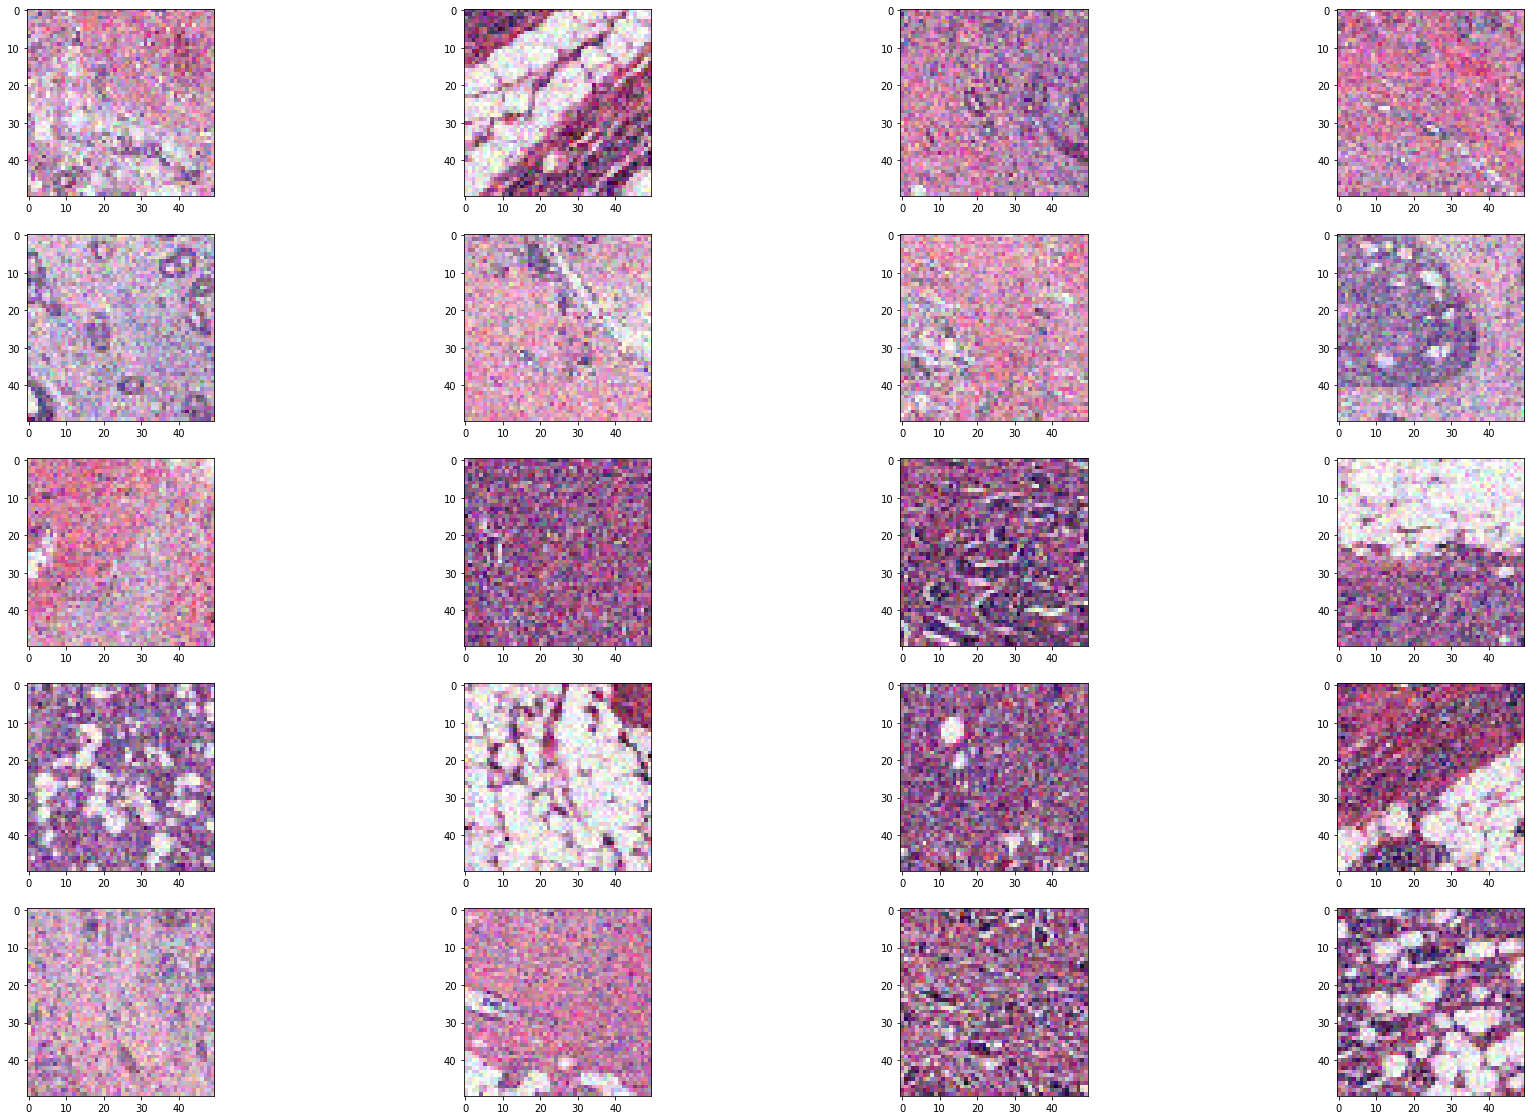

In [231]:
processd_data.target = processd_data.target.astype(np.int)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

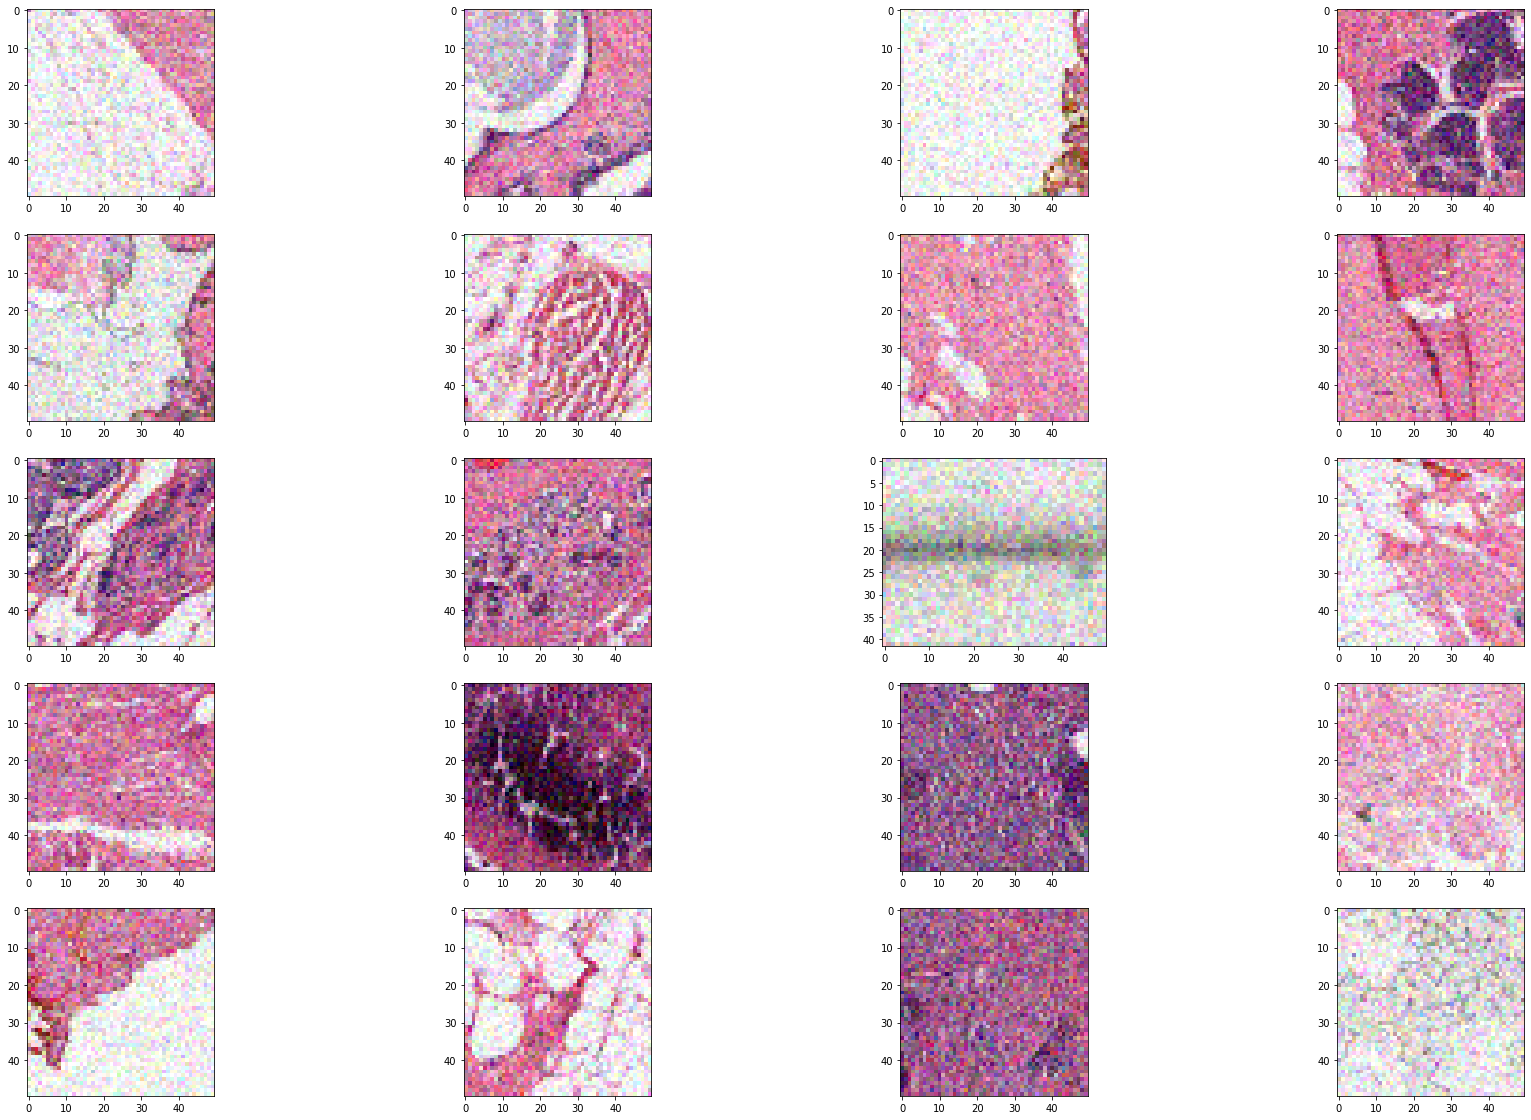

In [232]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [233]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 5978 images belonging to 2 classes.
Found 665 images belonging to 2 classes.


In [234]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [235]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit_generator(train_generation_processd,validation_data=test_generation_processd,epochs=60, verbose=1,callbacks=early_stop)

C:\Users\teste\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
598/598 [==============================] - 31s 51ms/step - loss: 0.3367 - accuracy: 0.8694 - val_loss: 0.4419 - val_accuracy: 0.8677
Epoch 2/60
598/598 [==============================] - 10s 16ms/step - loss: 0.2862 - accuracy: 0.8916 - val_loss: 0.2687 - val_accuracy: 0.8902
Epoch 3/60
598/598 [==============================] - 10s 16ms/step - loss: 0.2727 - accuracy: 0.8889 - val_loss: 0.2675 - val_accuracy: 0.8782
Epoch 4/60
598/598 [==============================] - 10s 16ms/step - loss: 0.2683 - accuracy: 0.8961 - val_loss: 0.2601 - val_accuracy: 0.8932
Epoch 5/60
598/598 [==============================] - 10s 16ms/step - loss: 0.2598 - accuracy: 0.8978 - val_loss: 0.2787 - val_accuracy: 0.8827
Epoch 6/60
598/598 [==============================] - 10s 16ms/step - loss: 0.2427 - accuracy: 0.9050 - val_loss: 0.4141 - val_accuracy: 0.8737


In [ ]:
os.mkdir( 'image_processing/normal')
os.mkdir( 'image_processing/normal/model_tst') 
os.mkdir( 'image_processing/normal/model_tst/trainig')
os.mkdir( 'image_processing/normal/model_tst/testing')
os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [ ]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit_generator(train_generation_normal,validation_data=test_generation_normal,epochs=60, verbose=1,callbacks=early_stop)

In [ ]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
# data = data.drop(['image_id'], axis=1)
# train_ds, test_ds = train_test_split(data, test_size=0.10, random_state=101)
# train_ds['target'].value_counts()
# test_ds['target'].value_counts()
# img_height = 50
# img_width = 50

# num_classes = 5

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.summary()
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=test_ds,
#   epochs=epochs
# )
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()